In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 09:28:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   42C    P0    30W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  concatted = tf.keras.layers.Concatenate()([x1, x2])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 66s 125ms/step - loss: 0.5304 - accuracy: 0.7869 - val_loss: 0.3596 - val_accuracy: 0.8605
Epoch 2/100
360/360 [==============================] - 36s 100ms/step - loss: 0.3993 - accuracy: 0.8343 - val_loss: 0.3411 - val_accuracy: 0.8689
Epoch 3/100
360/360 [==============================] - 39s 109ms/step - loss: 0.3807 - accuracy: 0.8437 - val_loss: 0.3333 - val_accuracy: 0.8656
Epoch 4/100
360/360 [==============================] - 36s 99ms/step - loss: 0.3611 - accuracy: 0.8554 - val_loss: 0.3458 - val_accuracy: 0.8706
Epoch 5/100
360/360 [==============================] - 35s 98ms/step - loss: 0.3383 - accuracy: 0.8632 - val_loss: 0.3022 - val_accuracy: 0.8783
Epoch 6/100
360/360 [==============================] - 36s 100ms/step - loss: 0.3226 - accuracy:

Epoch 56/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2236 - accuracy: 0.9125 - val_loss: 0.2265 - val_accuracy: 0.9159
Epoch 57/100
360/360 [==============================] - 36s 100ms/step - loss: 0.2214 - accuracy: 0.9114 - val_loss: 0.2211 - val_accuracy: 0.9184
Epoch 58/100
360/360 [==============================] - 35s 97ms/step - loss: 0.2211 - accuracy: 0.9142 - val_loss: 0.2163 - val_accuracy: 0.9220
Epoch 59/100
360/360 [==============================] - 34s 96ms/step - loss: 0.2163 - accuracy: 0.9126 - val_loss: 0.2320 - val_accuracy: 0.9154
Epoch 60/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2222 - accuracy: 0.9104 - val_loss: 0.2234 - val_accuracy: 0.9172
Epoch 61/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2184 - accuracy: 0.9121 - val_loss: 0.2197 - val_accuracy: 0.9191
Epoch 62/100
360/360 [==============================] - 35s 98ms/step - loss: 0.2227 - accuracy: 0.9131 - val_loss: 0.2246 

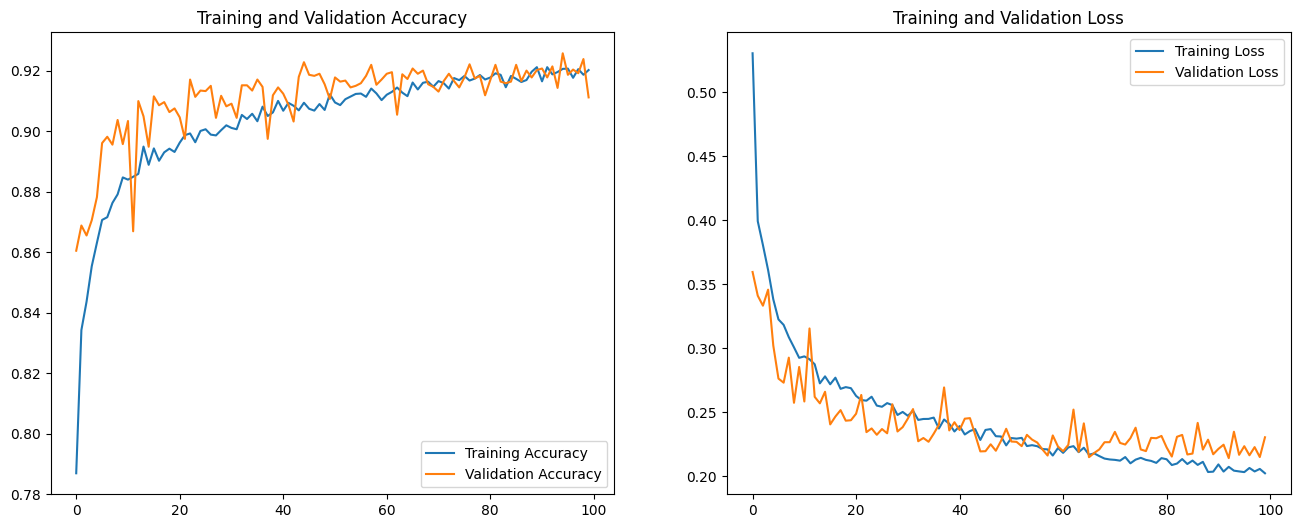

In [4]:
# DenseNet169 XYZ* + DenseNet201 XYZ*
conf1 = train_model()

In [5]:
np.max(conf1['val_acc'])

0.92584228515625

In [6]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 78s 152ms/step - loss: 0.5469 - accuracy: 0.7817 - val_loss: 0.3539 - val_accuracy: 0.8545
Epoch 2/100
360/360 [==============================] - 49s 136ms/step - loss: 0.4023 - accuracy: 0.8327 - val_loss: 0.3225 - val_accuracy: 0.8685
Epoch 3/100
360/360 [==============================] - 47s 131ms/step - loss: 0.3676 - accuracy: 0.8508 - val_loss: 0.3128 - val_accuracy: 0.8711
Epoch 4/100
360/360 [==============================] - 47s 130ms/step - loss: 0.3441 - accuracy: 0.8593 - val_loss: 0.2952 - val_accuracy: 0.8913
Epoch 5/100
360/360 [==============================] - 46s 128ms/step - loss: 0.3297 - accuracy: 0.8680 - val_loss: 0.2796 - val_accuracy: 0.9008
Epoch 6/100
360/360 [==============================] - 46s 129ms/step - loss: 0.3163 - accurac

360/360 [==============================] - 46s 127ms/step - loss: 0.2109 - accuracy: 0.9167 - val_loss: 0.2134 - val_accuracy: 0.9205
Epoch 56/100
360/360 [==============================] - 46s 128ms/step - loss: 0.2059 - accuracy: 0.9203 - val_loss: 0.2299 - val_accuracy: 0.9151
Epoch 57/100
360/360 [==============================] - 45s 126ms/step - loss: 0.2127 - accuracy: 0.9184 - val_loss: 0.2272 - val_accuracy: 0.9140
Epoch 58/100
360/360 [==============================] - 45s 126ms/step - loss: 0.2100 - accuracy: 0.9192 - val_loss: 0.2041 - val_accuracy: 0.9238
Epoch 59/100
360/360 [==============================] - 46s 128ms/step - loss: 0.2087 - accuracy: 0.9189 - val_loss: 0.2100 - val_accuracy: 0.9232
Epoch 60/100
360/360 [==============================] - 45s 126ms/step - loss: 0.2073 - accuracy: 0.9205 - val_loss: 0.2270 - val_accuracy: 0.9137
Epoch 61/100
360/360 [==============================] - 47s 130ms/step - loss: 0.2047 - accuracy: 0.9193 - val_loss: 0.2212 - val_a

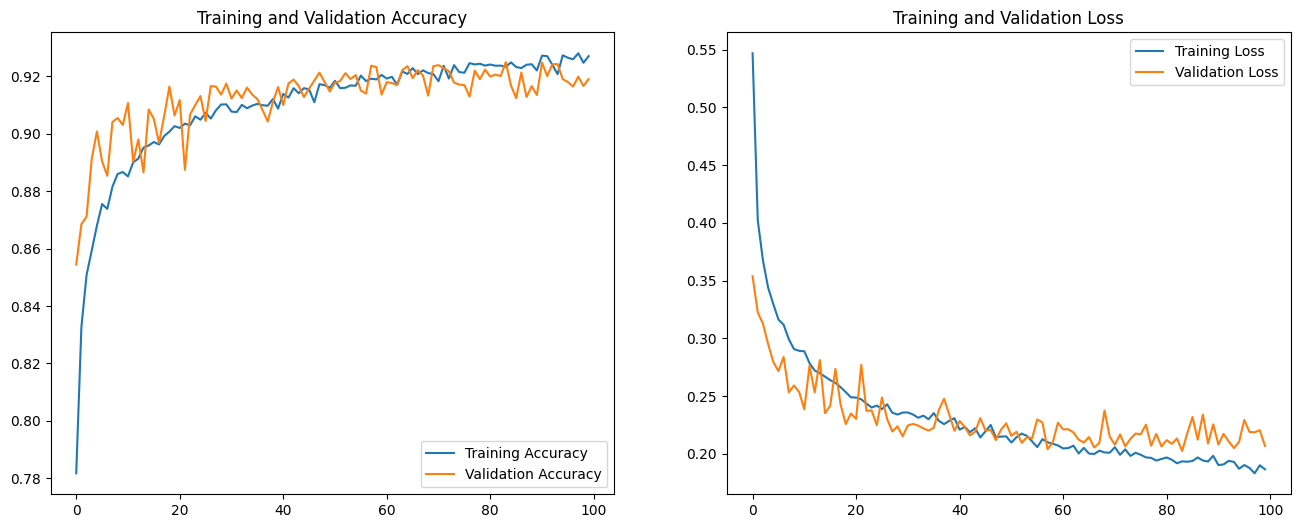

In [7]:
# DenseNet169 XYZ* + DenseNet201 XYZ* + DenseNet121 XYZ*
conf2 = train_model()

In [8]:
np.max(conf2['val_acc'])

0.9249739646911621

In [9]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 73s 147ms/step - loss: 0.5036 - accuracy: 0.8045 - val_loss: 0.3525 - val_accuracy: 0.8598
Epoch 2/100
360/360 [==============================] - 48s 133ms/step - loss: 0.3715 - accuracy: 0.8501 - val_loss: 0.3431 - val_accuracy: 0.8605
Epoch 3/100
360/360 [==============================] - 46s 129ms/step - loss: 0.3501 - accuracy: 0.8586 - val_loss: 0.2842 - val_accuracy: 0.8899
Epoch 4/100
360/360 [==============================] - 47s 131ms/step - loss: 0.3292 - accuracy: 0.8663 - val_loss: 0.2859 - val_accuracy: 0.8871
Epoch 5/100
360/360 [==============================] - 46s 128ms/step - loss: 0.3175 - accuracy: 0.8745 - val_loss: 0.2866 - val_accuracy: 0.8920
Epoch 6/100
360/360 [==============================] - 46s 128ms/step - loss: 0.3057 - accurac

360/360 [==============================] - 46s 128ms/step - loss: 0.1911 - accuracy: 0.9249 - val_loss: 0.2200 - val_accuracy: 0.9212
Epoch 56/100
360/360 [==============================] - 46s 127ms/step - loss: 0.1963 - accuracy: 0.9240 - val_loss: 0.2182 - val_accuracy: 0.9189
Epoch 57/100
360/360 [==============================] - 47s 130ms/step - loss: 0.1924 - accuracy: 0.9250 - val_loss: 0.2230 - val_accuracy: 0.9203
Epoch 58/100
360/360 [==============================] - 46s 129ms/step - loss: 0.1944 - accuracy: 0.9233 - val_loss: 0.2314 - val_accuracy: 0.9140
Epoch 59/100
360/360 [==============================] - 47s 131ms/step - loss: 0.1930 - accuracy: 0.9252 - val_loss: 0.2239 - val_accuracy: 0.9184
Epoch 60/100
360/360 [==============================] - 46s 127ms/step - loss: 0.1933 - accuracy: 0.9232 - val_loss: 0.2420 - val_accuracy: 0.9121
Epoch 61/100
360/360 [==============================] - 46s 128ms/step - loss: 0.1886 - accuracy: 0.9262 - val_loss: 0.2185 - val_a

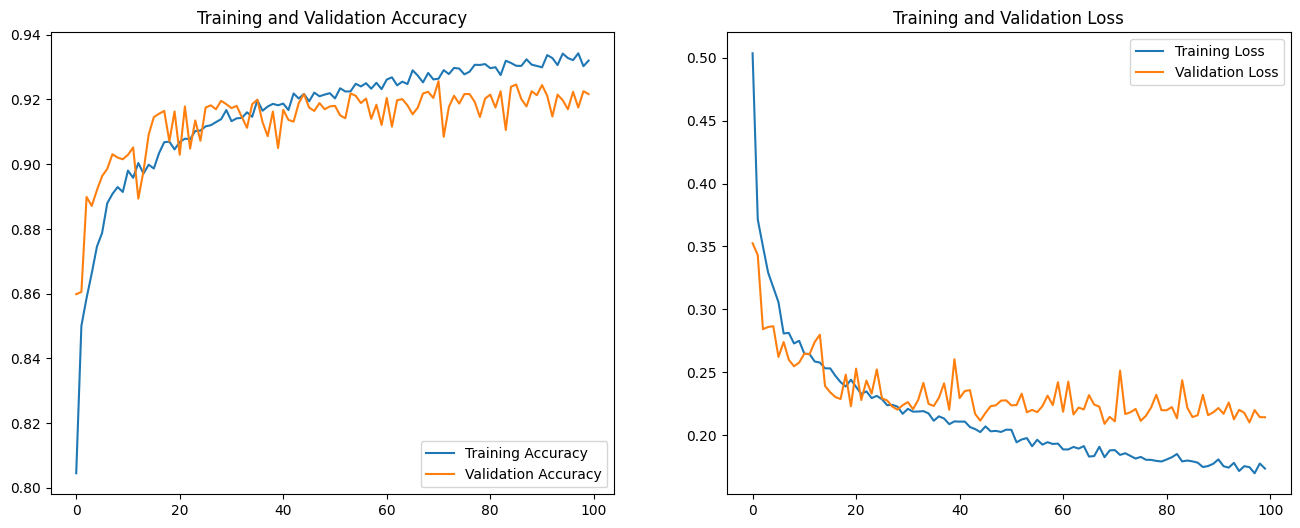

In [10]:
# DenseNet169 XYZ* + DenseNet201 XYZ* + Xception XYZ*
conf3 = train_model()

In [11]:
np.max(conf3['val_acc'])

0.9256686568260193

In [12]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    pathlib.Path('content/img_RGB'),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model_1 = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_1.trainable = False
    
    # Create the base model from the pre-trained model
  base_model_2 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_2.trainable = False  

      
    # Create the base model from the pre-trained model
  base_model_3 = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_3.trainable = False    
    
    
    
    # Create the base model from the pre-trained model
  base_model_4 = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  base_model_4.trainable = False  
    
  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  x = tf.keras.layers.Rescaling(scale=1./255)(x)
  x = tfio.experimental.color.rgb_to_xyz(x)
  print("Using the converted colors")

#     x = tf.keras.applications.densenet.preprocess_input(x)
#     print("Using preprocessing")

  x1 = base_model_1(x)
  x1 = tf.keras.layers.MaxPooling2D()(x1)
  x1 = tf.keras.layers.Dropout(0.2)(x1)
  x1 = tf.keras.layers.Flatten()(x1)
    
  x2 = base_model_2(x)  
  x2 = tf.keras.layers.MaxPooling2D()(x2)
  x2 = tf.keras.layers.Dropout(0.2)(x2)
  x2 = tf.keras.layers.Flatten()(x2)
    
  x3 = base_model_3(x)  
  x3 = tf.keras.layers.MaxPooling2D()(x3)
  x3 = tf.keras.layers.Dropout(0.2)(x3)
  x3 = tf.keras.layers.Flatten()(x3)    
    
  x4 = base_model_4(x)  
  x4 = tf.keras.layers.MaxPooling2D()(x4)
  x4 = tf.keras.layers.Dropout(0.2)(x4)
  x4 = tf.keras.layers.Flatten()(x4)  
    
  concatted = tf.keras.layers.Concatenate()([x1, x2, x3, x4])

  concatted = tf.keras.layers.Dense(512, activation='relu')(concatted)
  concatted = tf.keras.layers.Dropout(0.2)(concatted)
  concatted = tf.keras.layers.Dense(128, activation='relu')(concatted)
  outputs = tf.keras.layers.Dense(5)(concatted)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

In [13]:
conf4 = train_model()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 90s 180ms/step - loss: 0.5439 - accuracy: 0.7920 - val_loss: 0.3612 - val_accuracy: 0.8506
Epoch 2/100
360/360 [==============================] - 57s 159ms/step - loss: 0.3734 - accuracy: 0.8491 - val_loss: 0.3319 - val_accuracy: 0.8706
Epoch 3/100
360/360 [==============================] - 57s 160ms/step - loss: 0.3503 - accuracy: 0.8626 - val_loss: 0.2924 - val_accuracy: 0.8843
Epoch 4/100
360/360 [==============================] - 58s 161ms/step - loss: 0.3331 - accuracy: 0.8650 - val_loss: 0.3007 - val_accuracy: 0.8895
Epoch 5/100
360/360 [==============================] - 57s 159ms/step - loss: 0.3223 - accuracy: 0.8707 - val_loss: 0.2928 - val_accuracy: 0.8885
Epoch 6/100
360/360 [==============================] - 57s 159ms/step - loss: 0.2987 - accurac

360/360 [==============================] - 57s 157ms/step - loss: 0.1727 - accuracy: 0.9335 - val_loss: 0.2357 - val_accuracy: 0.9154
Epoch 93/100
360/360 [==============================] - 56s 157ms/step - loss: 0.1756 - accuracy: 0.9307 - val_loss: 0.2076 - val_accuracy: 0.9224
Epoch 94/100
360/360 [==============================] - 57s 159ms/step - loss: 0.1787 - accuracy: 0.9293 - val_loss: 0.2284 - val_accuracy: 0.9095
Epoch 95/100
360/360 [==============================] - 56s 157ms/step - loss: 0.1722 - accuracy: 0.9338 - val_loss: 0.2041 - val_accuracy: 0.9257
Epoch 96/100
360/360 [==============================] - 57s 158ms/step - loss: 0.1725 - accuracy: 0.9330 - val_loss: 0.2163 - val_accuracy: 0.9205
Epoch 97/100
360/360 [==============================] - 56s 157ms/step - loss: 0.1737 - accuracy: 0.9319 - val_loss: 0.2110 - val_accuracy: 0.9208
Epoch 98/100
360/360 [==============================] - 57s 158ms/step - loss: 0.1734 - accuracy: 0.9331 - val_loss: 0.2087 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
!mkdir ensembles
pd.DataFrame(conf1).to_csv("ensembles/conf1.csv", index=False)
pd.DataFrame(conf2).to_csv("ensembles/conf2.csv", index=False)
pd.DataFrame(conf3).to_csv("ensembles/conf3.csv", index=False)
pd.DataFrame(conf4).to_csv("ensembles/conf4.csv", index=False)